In [2]:
from transformers import BertForMaskedLM, BertTokenizerFast
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader
from src.dataset import TurtleSoupDataset
from src.utils import plot_training_validation_loss, plot_training_validation_acc, save_training_results
from src.model import PET, DiffPET
from run import train_pet_model

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
model = BertForMaskedLM.from_pretrained("bert-base-chinese").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [5]:
batch_size = 4
epochs = 10
learning_rate = 1e-5

template = "根據判定規則，此玩家的猜測為[MASK]"
label_map = {
    "T": "是",
    "F": "否",
    "N": "不"
}

In [6]:
train_data_path = "./data/TurtleBench-extended-zh/train_8k.json"
test_data_path = "./data/TurtleBench-extended-zh/test_1.5k.json"
prompt_path = "./prompts/prompt_zh.json"

In [7]:
train_dataset = TurtleSoupDataset(train_data_path, prompt_path, tokenizer, max_length=512, template=template, label_map=label_map, contrastive_learning=-True)
test_dataset = TurtleSoupDataset(test_data_path, prompt_path, tokenizer, max_length=512, template=template, label_map=label_map)

# 創建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
data = next(iter(train_dataloader))

## PET

In [9]:
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_training_steps = len(train_dataloader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

c:\Users\wei\Desktop\programs\deep learning\turtle-soup-lateral-thinking-game\model\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
pet_model = PET(model, tokenizer, device)

train_losses, train_accuracies, val_losses, val_accuracies = train_pet_model(pet_model, train_dataloader, val_dataloader, optimizer, lr_scheduler, epochs=epochs)

Epoch 1/10: 100%|██████████| 2022/2022 [16:13<00:00,  2.08it/s]


train_loss: 2.391, val_loss: 1.200, train_acc: 0.589, val_acc: 0.492


Epoch 2/10: 100%|██████████| 2022/2022 [16:15<00:00,  2.07it/s]


train_loss: 0.600, val_loss: 1.288, train_acc: 0.837, val_acc: 0.528


Epoch 3/10: 100%|██████████| 2022/2022 [16:18<00:00,  2.07it/s]


train_loss: 0.328, val_loss: 1.790, train_acc: 0.947, val_acc: 0.519


Epoch 4/10: 100%|██████████| 2022/2022 [16:18<00:00,  2.07it/s]


train_loss: 0.225, val_loss: 1.717, train_acc: 0.973, val_acc: 0.549


Epoch 5/10: 100%|██████████| 2022/2022 [15:53<00:00,  2.12it/s]


train_loss: 0.168, val_loss: 1.972, train_acc: 0.984, val_acc: 0.536


Epoch 6/10: 100%|██████████| 2022/2022 [15:50<00:00,  2.13it/s]


train_loss: 0.142, val_loss: 2.576, train_acc: 0.988, val_acc: 0.526


Epoch 7/10: 100%|██████████| 2022/2022 [15:50<00:00,  2.13it/s]


train_loss: 0.100, val_loss: 2.649, train_acc: 0.993, val_acc: 0.531


Epoch 8/10: 100%|██████████| 2022/2022 [15:50<00:00,  2.13it/s]


train_loss: 0.078, val_loss: 2.606, train_acc: 0.995, val_acc: 0.535


Epoch 9/10: 100%|██████████| 2022/2022 [15:49<00:00,  2.13it/s]


train_loss: 0.063, val_loss: 3.295, train_acc: 0.996, val_acc: 0.538


Epoch 10/10: 100%|██████████| 2022/2022 [15:49<00:00,  2.13it/s]


train_loss: 0.055, val_loss: 3.513, train_acc: 0.997, val_acc: 0.524


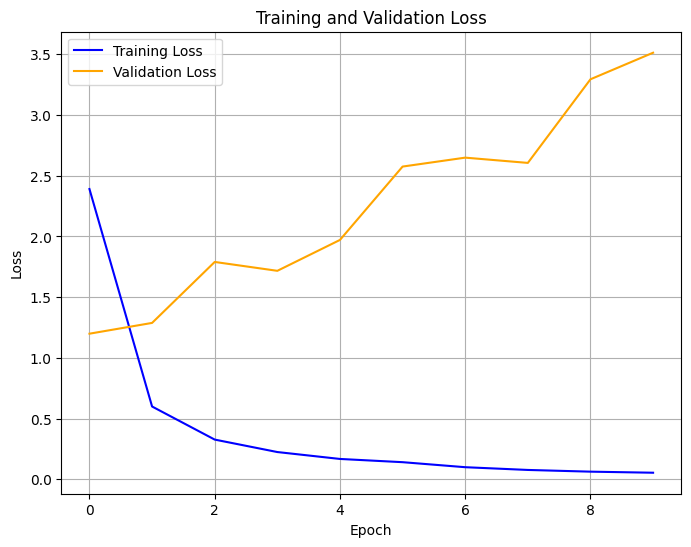

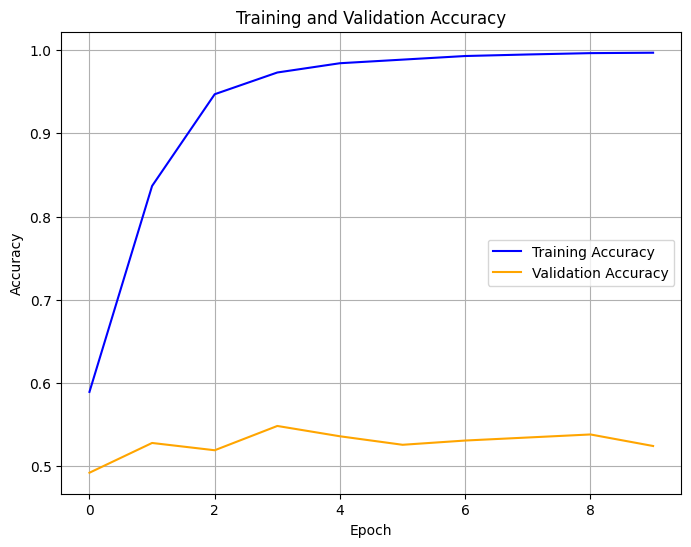

In [12]:
plot_training_validation_loss(train_losses, val_losses)
plot_training_validation_acc(train_accuracies, val_accuracies)

In [ ]:
# pet_model.save_model("./params/contrastive/bert-turtle-soup-pet-zh")
# save_training_results("pet_zh", train_losses, train_accuracies, val_losses, val_accuracies, save_dir='results/contrastive')

Results saved to: results/contrastive\pet_zh_results.json


## DiffPET

In [7]:
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_training_steps = len(train_dataloader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

c:\Users\wei\Desktop\programs\deep learning\turtle-soup-lateral-thinking-game\model\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
torch.cuda.empty_cache()

In [9]:
labels = ['是', '否', '不']

In [10]:
diff_pet_model = DiffPET(model, tokenizer, template, labels, device)

train_losses, train_accuracies, val_losses, val_accuracies = train_pet_model(diff_pet_model, train_dataloader, val_dataloader, optimizer, lr_scheduler, epochs=epochs)

Epoch 1/10: 100%|██████████| 998/998 [04:07<00:00,  4.04it/s]


train_loss: 0.935, val_loss: 1.823, train_acc: 0.625, val_acc: 0.566


Epoch 2/10: 100%|██████████| 998/998 [04:03<00:00,  4.10it/s]


train_loss: 0.293, val_loss: 2.442, train_acc: 0.887, val_acc: 0.595


Epoch 3/10: 100%|██████████| 998/998 [04:01<00:00,  4.13it/s]


train_loss: 0.110, val_loss: 3.196, train_acc: 0.964, val_acc: 0.579


Epoch 4/10: 100%|██████████| 998/998 [04:03<00:00,  4.10it/s]


train_loss: 0.062, val_loss: 3.308, train_acc: 0.979, val_acc: 0.588


Epoch 5/10: 100%|██████████| 998/998 [04:04<00:00,  4.08it/s]


train_loss: 0.041, val_loss: 3.701, train_acc: 0.985, val_acc: 0.578


Epoch 6/10: 100%|██████████| 998/998 [04:01<00:00,  4.13it/s]


train_loss: 0.031, val_loss: 4.105, train_acc: 0.989, val_acc: 0.592


Epoch 7/10: 100%|██████████| 998/998 [04:03<00:00,  4.10it/s]


train_loss: 0.016, val_loss: 4.128, train_acc: 0.995, val_acc: 0.589


Epoch 8/10: 100%|██████████| 998/998 [04:03<00:00,  4.09it/s]


train_loss: 0.012, val_loss: 4.145, train_acc: 0.995, val_acc: 0.599


Epoch 9/10: 100%|██████████| 998/998 [04:03<00:00,  4.10it/s]


train_loss: 0.008, val_loss: 4.187, train_acc: 0.997, val_acc: 0.583


Epoch 10/10: 100%|██████████| 998/998 [04:02<00:00,  4.12it/s]


train_loss: 0.005, val_loss: 4.319, train_acc: 0.998, val_acc: 0.594


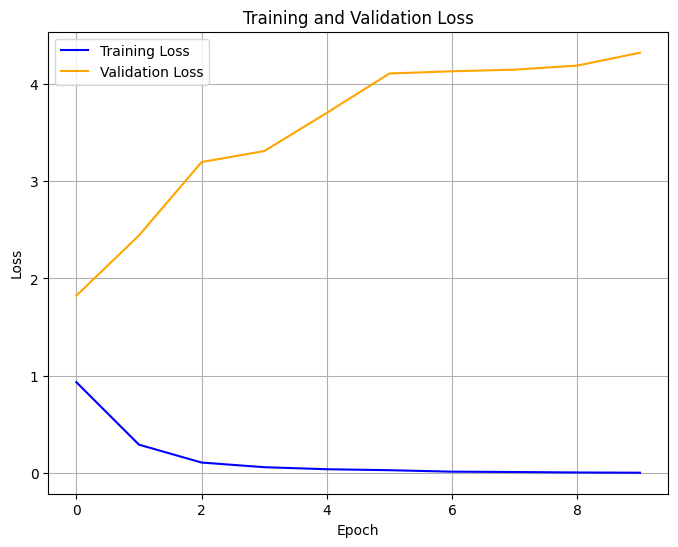

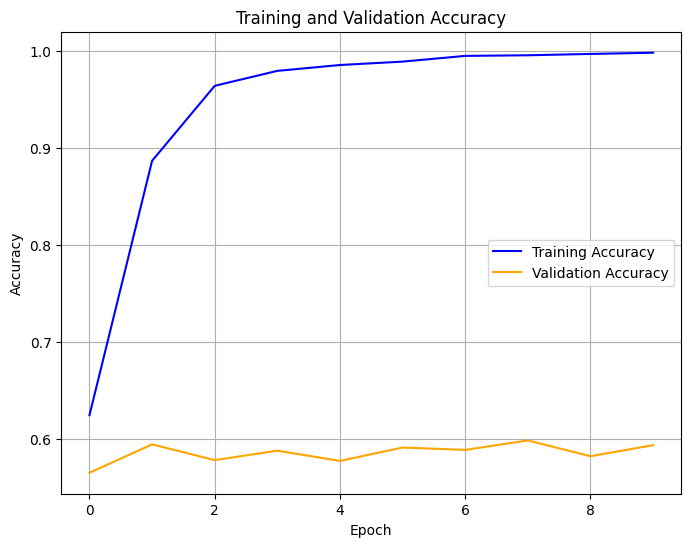

In [11]:
plot_training_validation_loss(train_losses, val_losses)
plot_training_validation_acc(train_accuracies, val_accuracies)

In [12]:
# diff_pet_model.save_model("./params/contrastive/bert-turtle-soup-diffpet-zh")
# save_training_results("diffpet_zh", train_losses, train_accuracies, val_losses, val_accuracies, save_dir='contrastive/results')

## TEST

In [7]:
torch.cuda.empty_cache()

In [8]:
model = BertForMaskedLM.from_pretrained("./params/pet_model").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

labels = ['是', '否', '不']
template = "根據判定規則，此玩家的猜測為[MASK]"

pet = PET(model, tokenizer, device)

In [9]:
import json
import random

with open(test_data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 載入 Prompt 檔案，包含 short, medium, long Prompt 的結構
with open(prompt_path, "r", encoding="utf-8") as f:
    prompts = json.load(f)

short_prompt = prompts["short"]
medium_prompt = prompts["medium"]
long_prompt = prompts["long"]

random_item = random.choice(data)

print('stroy: ', random_item['surface'])
print('answer: ', random_item['bottom'])
while True:
    user_guess = input("請輸入內容（輸入 'exit' 結束）：")
    if user_guess.lower() == 'exit':
        print("程式結束")
        break

    surface = random_item["surface"]  # 湯面部分
    bottom = random_item["bottom"]    # 湯底部分
    user_guess = user_guess  # 玩家猜測

    prompt_filled = medium_prompt["prompt"].format(surface=surface, bottom=bottom) + user_guess + ' 根據判定規則，此玩家的猜測為[MASK]'

    inputs = tokenizer(
        prompt_filled,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    
    model.eval()
    with torch.no_grad():
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # 前向傳播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        mask_token_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # print(logits[0, mask_token_index].shape)
        predicted_ids = torch.argmax(logits[0, mask_token_index], dim=-1)
        predicted_label = tokenizer.decode(predicted_ids, add_special_tokens=False)
        print(f"Predicted: {predicted_label}")

        # print(logits.shape)
        # predicted_ids = torch.argmax(logits, dim=-1)
        # print(predicted_ids[0])
        # predicted = tokenizer.decode(predicted_ids[0].tolist())

        # 顯示模型輸出的預測結果
        # print(f"Predicted: {[predicted]}")

stroy:  我走進電梯準備上學，隨著電梯的上升，我知道，我再也無法去學校了。
answer:  星期一早晨，在媽媽催促下我心不在焉地走進電梯去學校。由於剛醒來，我忘了按樓層，電梯持續上升。正當我想按樓層按鈕時，電梯突然停了，門緩緩打開，我看到一個女孩倒在血泊中，一個男人正在清理現場。男人聽到動靜，轉頭看向我，目光死死盯著我的手。我嚇得狂按關門鍵，眼看門即將關閉時，一隻帶血的手伸了進來。我再也沒能去學校，因為被兇手拖出電梯殺害了。
Predicted: 否
Predicted: 否
Predicted: 不
Predicted: 是
Predicted: 否
Predicted: 否
Predicted: 是
Predicted: 否
Predicted: 是
Predicted: 是
Predicted: 是
Predicted: 否
程式結束


In [13]:
import json
import random
from torch.utils.data import Dataset, DataLoader
import torch

class ContrastiveDataset(Dataset):
    def __init__(self, json_file, max_len=128, tokenizer=None):
        """
        初始化對比學習數據集。
        :param json_file: 包含數據的 JSON 文件路徑
        :param max_len: 最大序列長度
        :param tokenizer: BERT 的分詞器
        """
        with open(json_file, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.samples = self._create_samples()

    def _create_samples(self):
        """
        創建正樣本與負樣本對。
        :return: list，包含 (input_ids_a, input_ids_b, label) 的樣本對
        """
        samples = []
        
        for story in self.data:
            surface = story['surface']
            bottom = story['bottom']
            user_guess = story['user_guess']
            label = story['label']

            # 正樣本對 (Positive Pairs)
            if label == "T":
                # 玩家猜測正確：與 surface 和 bottom 匹配
                samples.append((user_guess, surface, 1))  # Positive Pair with surface
                samples.append((user_guess, bottom, 1))   # Positive Pair with bottom
            elif label == "N":
                # 無法判斷的猜測：與 surface 匹配，但模糊
                samples.append((user_guess, surface, 1))  # Positive Pair with surface
            
            # 負樣本對 (Negative Pairs)
            if label == "F":
                # 玩家猜測錯誤：與 surface 和 bottom 衝突
                samples.append((user_guess, surface, 0))  # Negative Pair with surface
                samples.append((user_guess, bottom, 0))   # Negative Pair with bottom

            # 添加跨故事干擾樣本 (Cross-Story Negative Pairs)
            other_story = random.choice(self.data)
            if other_story['id'] != story['id']:
                other_surface = other_story['surface']
                samples.append((user_guess, other_surface, 0))  # Negative Pair with unrelated surface

        return samples

    def _tokenize_pair(self, text_a, text_b):
        """
        將兩段文本進行 BERT 分詞和編碼。
        :param text_a: 第一段文本
        :param text_b: 第二段文本
        :return: 編碼的 input_ids, attention_mask, token_type_ids
        """
        encoding = self.tokenizer(
            text_a,
            text_b,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), encoding['token_type_ids'].squeeze(0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        獲取樣本對並進行編碼。
        :param idx: 样本索引
        :return: 編碼的 input_ids_a, input_ids_b, attention_mask_a, attention_mask_b, label
        """
        text_a, text_b, label = self.samples[idx]
        input_ids, attention_mask, token_type_ids = self._tokenize_pair(text_a, text_b)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'label': torch.tensor(label, dtype=torch.float)
        }

# 測試代碼

from transformers import BertTokenizer

# 初始化分詞器
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
json_file = "data\TurtleBench-extended-zh\\train_8k.json"  # 替換為你的 JSON 文件路徑

# 創建數據集
dataset = ContrastiveDataset(json_file, max_len=512, tokenizer=tokenizer)

# 測試數據加載
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
for batch in dataloader:
    print("Input IDs:", batch['input_ids'].shape)
    print("Attention Mask:", batch['attention_mask'].shape)
    print("Token Type IDs:", batch['token_type_ids'].shape)
    print("Labels:", batch['label'])
    break


Input IDs: torch.Size([4, 512])
Attention Mask: torch.Size([4, 512])
Token Type IDs: torch.Size([4, 512])
Labels: tensor([0., 1., 0., 1.])
